In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import networkx as nx
import numpy as np

In [2]:
header = ['id_arc', 'node_from', 'node_to', 'id_arc_type', 'id_comuna', 'id_street'] + list(range(0, 48))

with open('data/travelTimeProfile.csv', 'r') as file:
    df = pd.read_csv(file, header=0, names=header)
    for i in range(0, 48):
        df[i] = df[i]/100.0

In [3]:
print(df)

      id_arc   node_from     node_to  id_arc_type  id_comuna  id_street     0  \
0  774868639  7231168198  7231168176            1          8          8  12.9   

      1     2     3  ...    38    39    40    41    42    43    44    45  \
0  12.9  12.9  12.9  ...  25.5  25.5  17.1  17.1  12.9  12.9  12.9  12.9   

     46    47  
0  12.9  12.9  

[1 rows x 54 columns]


In [4]:
def get_travel_time_profile(df, node_from_or_arc, node_to=None):
    if node_to:
        for row_index, node_from in enumerate(df['node_from']):
            if node_from == node_from_or_arc and df.iloc[row_index]['node_to'] == node_to:
                row = df.iloc[row_index]
    else:
        for row_index, id_arc in enumerate(df['id_arc']):
            if id_arc == node_from_or_arc:
                row = df.iloc[row_index]
    info = {'id_arc': row['id_arc'], 'node_from': row['node_from'], 'node_to': row['node_to'], 
            'id_arc_type': row['id_arc_type'], 'id_comuna':row['id_comuna'], 'id_street': row['id_street']}
    return row[6:], [1800*x for x in range(0, 48)], info

{'id_arc': 774868639.0, 'node_from': 7231168198.0, 'node_to': 7231168176.0, 'id_arc_type': 1.0, 'id_comuna': 8.0, 'id_street': 8.0}


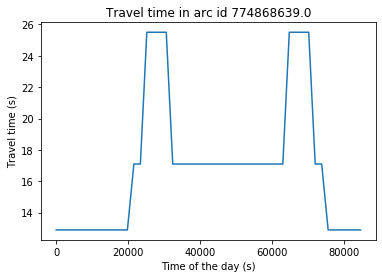

In [5]:
travel_times, times_of_day, info = get_travel_time_profile(df, 774868639)

print(info)

plt.plot(times_of_day, travel_times)
plt.xlabel('Time of the day (s)')
plt.ylabel('Travel time (s)')
plt.title('Travel time in arc id '+str(info['id_arc']))
plt.show()

{'id_arc': 774868639.0, 'node_from': 7231168198.0, 'node_to': 7231168176.0, 'id_arc_type': 1.0, 'id_comuna': 8.0, 'id_street': 8.0}


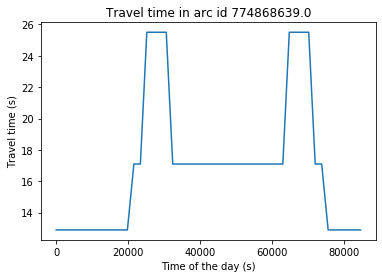

In [6]:
travel_times, times_of_day, info = get_travel_time_profile(df, 7231168198, 7231168176) # arc id 4475350870

print(info)

plt.plot(times_of_day, travel_times)
plt.xlabel('Time of the day (s)')
plt.ylabel('Travel time (s)')
plt.title('Travel time in arc id '+str(info['id_arc']))
plt.show()

{'id': '774868639', 'from': '7231168198', 'to': '7231168176', 'priority': '12', 'type': 'highway.primary', 'numLanes': '3', 'speed': '27.78', 'shape': '2147.68,3389.15 2145.34,3288.69', 'spreadType': 'center'}
edge length: 100.48724894234097


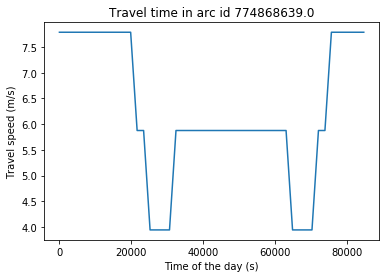

In [7]:
travel_times, times_of_day, info = get_travel_time_profile(df, 7231168198, 7231168176) # arc id 4475350870

edges_data = ET.parse('data/macul.edg.xml').getroot()

def get_edge_info(edges, id_edge):
    for edge in edges:
        if int(edge.get('id')) == id_edge:
            return edge.attrib
    return None

edge_attrib = get_edge_info(edges_data, 774868639)
print(edge_attrib)

edge_loc = edge_attrib['shape'].split()
n0 = [float(x) for x in edge_loc[0].split(',')]
n1 = [float(x) for x in edge_loc[1].split(',')]

edge_length = np.sqrt((n1[0]-n0[0])**2 + (n1[1]-n0[1])**2)
print('edge length:', edge_length)

velocities = edge_length/np.asarray(travel_times)

plt.plot(times_of_day, velocities)
plt.xlabel('Time of the day (s)')
plt.ylabel('Travel speed (m/s)')
plt.title('Travel time in arc id '+str(info['id_arc']))
plt.show()

In [16]:
def TSubElement(parent, tag, attrib={}, text=None, **extra):
    element = ET.SubElement(parent, tag, attrib, **extra)
    if text:
        element.text = text
    return element

In [21]:
_additional = ET.Element('additional')

# <routeProbe id="cali_edge1_probe" edge="774868639" freq="5" file="output-routeprobe.xml"/>
routeProbeAttrib = {'id':'cali_edge1_probe', 'edge':'774868639', 
                    'freq':'5', 'file':'output-routeprobe.xml'}

# <calibrator id="calibtest_edge" edge="774868639" freq="2" pos="0" routeProbe="cali_edge1_probe">
calibratorAttrib = {'id':'calibtest_edge', 'edge':'774868639', 'freq':'2', 'pos':'0', 
                    'routeProbe':'cali_edge1_probe'}

_routeProbe = TSubElement(_additional, 'routeProbe', attrib=routeProbeAttrib)
_calibrator = TSubElement(_additional, 'calibrator', attrib=calibratorAttrib)

# <route id="cali1_fallback" edges="774868639"/>
_routeFallback = TSubElement(_calibrator, 'route', attrib={'id':'cali1_fallback', 'edges':'774868639'})

for t, vel in zip(times_of_day, velocities):
    flowAttrib = {'begin':str(t), 'end':str(t+30*60), 'route':'cali1_fallback', 'vehsPerHour':'3600', 
                  'speed':str(vel), 'departPos':'free', 'departSpeed':str(vel)}
    _flow = TSubElement(_calibrator, 'flow', attrib=flowAttrib)

calibrator_tree = ET.ElementTree(_additional)
calibrator_tree.write('data/calibrator-generated.add.xml')

## Import simulation data

In [29]:
def get_travel_times_from_xml(data, id_edge):
    time_of_day = []
    travel_times = []
    for interval in data:
        for edge in interval:
            if int(edge.get('id'))==id_edge:
                try:
                    travel_times.append(float(edge.get('traveltime')))
                    time_of_day.append(float(interval.get('begin')))
                except TypeError:
                    pass 
    return time_of_day, travel_times

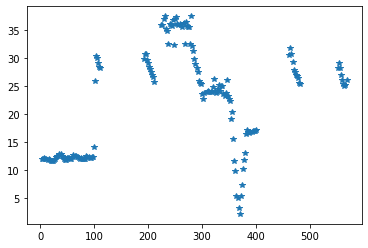

In [79]:
data = ET.parse('data/output-meas-edges.xml').getroot()
times_of_day, travel_times = get_travel_times_from_xml(data, 774868639)

velocities = edge_length/np.asarray(travel_times)

plt.plot(times_of_day, velocities, '*')

### Turn travel times into flow
Based on: R. Akcelik, 1996, "Relating flow, density, speed and travel time models for uninterrupted and interrupted traffic"

<img src="../pictures/timeDistanceRelationship.png" style="width: 500px">

We suppose that all vehicles move at the same speed. This **speed** is $$v=\dfrac{L_h}{h}.$$ Similarly, $v=\dfrac{L_v}{t_v}$. Notice that $L_h = L_s+L_v$, thus $L_s=L_h-L_v$. These assumptions lead to $$t_g=h-t_v=h-\dfrac{L_v}{v}=\dfrac{L_s}{v}.$$

The vehicle length $L_v$ is easily obtained if all vehicles are the same. If there are more than one type of vehicle, $L_v$ can be calculated as the weighted average of the vehicle lenghts, according their proportions.

**Flow** is $$q=\dfrac{1}{h}$$
**Density** is $$k=\dfrac{1}{L_h}$$

The relationship among speed and flow is known as the fundamental realtionship in traffic flow theory: $$q=vk$$

